Calibration package is being initialized.
POSE ESTIMATION STARTS:
=> Processing image ../node-red/projects/calib_4x4_2609/frame0000.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0001.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0002.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0003.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0004.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0005.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0006.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0007.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0008.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0009.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_4x4_2609/frame0010.png
(2128, 4200)
=> Processing image .

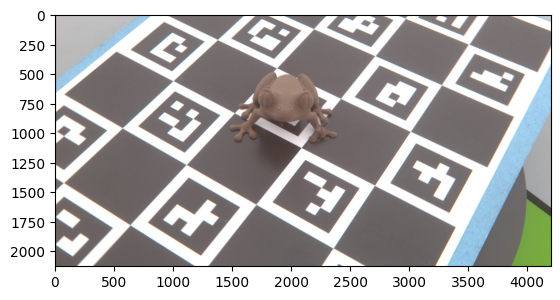

In [7]:
import sys
import os
import numpy as np
from pathlib import Path

# Add the path to 'lib' directory
sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

# Now try importing
from calibration.cv2api.calibrate import read_chessboards,calibrate_camera
from calibration.cv2api.detect import detect_pose
from config.ConfigManager import ConfigManager
from calibration.json_utils.json_functions import generate_json_for_images

config_manager = ConfigManager('config.json')


def calibrate_and_write(project_name,  output_folder):

    image_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".jpg") or f.endswith(".png")]
    image_files.sort()  # Ensure files are in order

    allCorners,allIds,imsize,num_of_detected_markers=read_chessboards(image_files)

    print(allCorners)


    ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
    print(ret,mtx)
    if(ret!=-1):
        np.save(os.path.join(output_folder,"camera_matrix.npy"), mtx)
        np.save(os.path.join(output_folder,"camera_dist_coeff.npy"),dist)
        config_manager.update_project(project_name, {"calibrated": True, "camera_matrix": mtx.tolist(),
                                                "dist_coeff": dist.tolist()})
        return mtx,dist
    else:
        print("no calibration data were found")
        return None, None 

    



# input_video = "../data/videos/bfrog_4x4.mp4"
# input_folder = None

input = "../node-red/projects/calib_4x4_2609//////"

output_folder = f"../node-red/projects/{Path(input).stem}"
project_name = "test"
mtx = None
dist = None
num_of_images = 40

if(os.path.isdir(input)):
    config_manager.update_project(project_name, {"images": output_folder})
    mtx,dist = calibrate_and_write(project_name, output_folder)
else:
    err = os.system(f"sfextract --frame-count {num_of_images} {input} --output {output_folder}")  
    if(err):
        print("Error occured while generating images from video")
    else:
        config_manager.update_project(project_name, {"images": output_folder})
        mtx,dist = calibrate_and_write("test", output_folder)

if mtx is not None and mtx.any():
    generate_json_for_images("../node-red/projects/bfrog_actual_path//",os.path.join("../node-red/projects/bfrog_actual_path/","transforms_centered.json"),mtx,dist,colmap = True)
else:
    print("Cannot do detection, to little charuco markers were found")


In [5]:
False >0

False

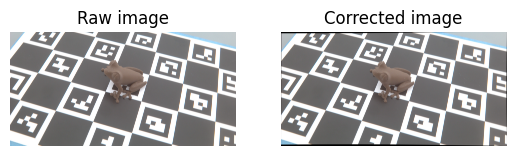

In [14]:
from matplotlib import pyplot as plt
import cv2


def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted_image

i=15 # select image id
plt.figure()
frame = cv2.imread("../node-red/projects/bfrog_actual_path//"+"/frame0011.png")
img_undist = undistort_image(frame,mtx,dist)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()


(4,
 array([[ 1.71791182],
        [ 0.35272588],
        [-1.3093041 ]]),
 array([[-0.18208368],
        [ 0.14535014],
        [ 0.25709302]]))

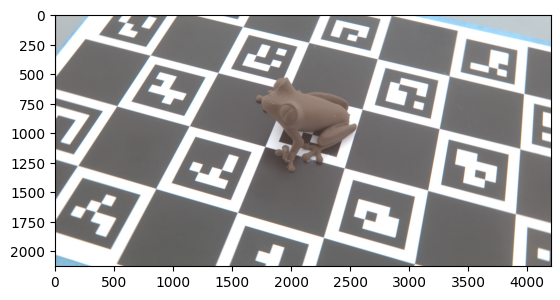

In [15]:
detect_pose(frame,mtx,dist)

In [2]:
from lib.calibration.viz_utils.viz_cameras import camera_with_frustums 

In [4]:
camera_with_frustums("../node-red/projects/benchmark_4x4_phone/transforms_centered.json","../node-red/projects/benchmark_4x4_phone/cameras.html")